In [1]:
import numpy as np, torch, numpy.random as npr, torch.nn as nn, copy, timeit
from torch.distributions.bernoulli import Bernoulli 
from HMCfunctions import *
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

Gradient w.r.t. $\theta$:

$$
\nabla_\theta \log p(\theta \mid \sigma, x_{1:n}, y_{1:n}) 
= 
- \sum_{i=1}^n \frac{\left ( \mu_\theta(x_i) - y_i \right ) \, \nabla_\theta \mu_\theta(x_i) }{\sigma^{2k}} + \nabla_\theta \log p_0(\theta) 
$$

#### Set up neural network:

In [2]:
n_in = 2
n_h1 = 2
n_out = 2

nn_model = nn.Sequential(nn.Linear(n_in, n_h1),
                         nn.LeakyReLU(),
                         nn.Linear(n_h1, n_out),
                         nn.LeakyReLU())

* Randomly initialise model parameters:

In [3]:
nn_model.apply(init_normal)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
)

#### Generate some random data:

In [4]:
batch_size = 100
x = torch.randn(batch_size, n_in, requires_grad=True)
y = torch.randn(batch_size, n_out)
criterion = nn.MSELoss()

* Get dimensions of parameters:

In [5]:
shapes = get_shapes(nn_model)

* Total number of parameters:

In [6]:
print(sum(p.numel() for p in nn_model.parameters()))

12


###  HMC

* First define the MCMC chain and randomly initialise it:

In [7]:
n_iter = 10**3
chain = []
for shape in shapes :
    chain_shape = list(shape)
    chain_shape.insert(0,n_iter)
    chain.append(torch.randn(chain_shape))
accepted = np.zeros(n_iter).astype(int)

* Specify HMC parameters:

In [8]:
delta_leapfrog = 2e-3
n_leapfrog = 10

* Then run HMC:

In [10]:
delta_leapfrog = 1e-4
sigma = 1
for t in range(n_iter) : 
    updated_nn_model, a = HMC_1step(nn_model, n_leapfrog, delta_leapfrog, shapes, x, y, criterion, sigma)
    accepted[t] = a
    for (i,param) in enumerate(nn_model.parameters()) :
        chain[i][t] = param
print(100*np.mean(accepted), "% accepted")

63.4 % accepted


#### Some traceplots:

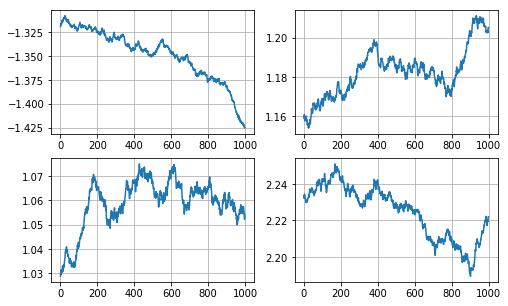

In [11]:
plt.figure(figsize=(8,5))
for i in range(2) :
    for j in range(2) :
        plt.subplot(2,2,2*i+j+1)
        plt.plot(list(chain[0][:,i,j].data))
        plt.grid(True)

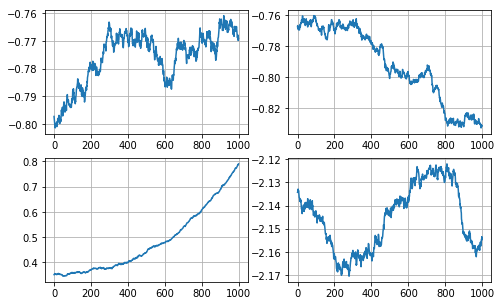

In [15]:
plt.figure(figsize=(8,5))
for i in range(2) :
    for j in range(2) :
        plt.subplot(2,2,2*i+j+1)
        plt.plot(list(chain[2][:,i,j].data))
        plt.grid(True)

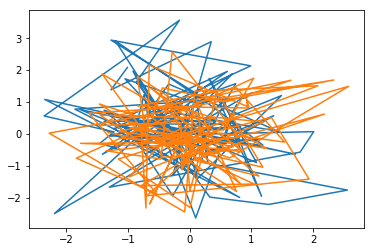

In [22]:
plt.plot(list(x[:,0]),list(x[:,1]))
plt.plot(list(y[:,0]),list(y[:,1]))